# Starbucks Capstone Challenge

## Project Overview

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app & it is a simplified version of the real Starbucks app as it only has one product whereas Starbucks actually sells dozens of products.. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. Additionally, Not all users receive the same offer.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. Also, it can be seen in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

transactional data is given showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Finally, keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


## Problem Statement

Analyzing customer behavior toward recieved offers from Starbucks app by creating clusters based on demographical inforamtion given about those customers, and providing insight that would help in enhancing the app by sending the offer to customrs who are truly intrested about it.

The questions that I want to answer are:
1. How many types of customers do we have?
2. How different types of customer responde to different types of offers?

## Metrics
The only metric that is used here is Calinski-Harabaz score to help in determining the proper number of clusters needed for the K mean clustring method. The Calinski-Harabasz score also known as the Variance Ratio Criterion, is the ratio of the sum of between-clusters dispersion and of inter-cluster dispersion for all clusters, the higher the score , the better the performances.

### Section 1: Data Investigation and Cleaning
#### In this section the data will be uploaded, investigated, and cleaned

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import calinski_harabaz_score

import seaborn as sns

% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

1. Looking at each uploaded file

In [2]:
portfolio.head(10)

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [3]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [4]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [5]:
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


In [6]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


In [7]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


2. The findings from the initial investigation are the following:
   * Profile dataframe has 2175 missing data.
   * Some values under "age" column in Profile data frame has what seems to be unrealistic data for people with age of 118
   * Transcript dataframe, "value" column, needs to be cleaned to show only the transaction ID to be able to join it with Portfolio dataframe

In [8]:
#cleaning the value column to have only the offer ID itself
transcript_1 = transcript.copy() 
transcript_1['value'] = transcript_1['value'].astype(str)
transcript_1['value']= transcript_1.value.str.replace(r"[{':'}]", '')
transcript_1['value']= transcript_1.value.str.replace(r"offer id", '')
transcript_1['value']= transcript_1.value.str.strip()
transcript_1['value'] = transcript_1.value.str.replace(r"offer_id ", '')
transcript_1['value'] = transcript_1.value.str.replace(r"(, reward \d*)", '')
transcript_1.rename(columns={"value": "id"}, inplace = True)

The values column is changed to ID to facilitate the merging process with portfolio dataframe

In [9]:
transcript_1.head()

,event,person,time,id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,4d5c57ea9a6940dd891ad53e9dbe8da0


In [10]:
#To check that the ID value is extracted proparly for each type of event

#First find the number of unique values under events column
transcript_1.groupby('event')[['event']].count()

,event
event,
offer completed,33579
offer received,76277
offer viewed,57725
transaction,138953


In [11]:
#Since there four unique values, one column from each would be suffeciant
transcript_1[transcript_1['event'] == 'offer completed'].head(1)

,event,person,time,id
12658,offer completed,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,0,2906b810c7d4411798c6938adc9daaa5


In [12]:
transcript_1[transcript_1['event'] == 'offer received'].head(1)

,event,person,time,id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9


In [13]:
transcript_1[transcript_1['event'] == 'offer viewed'].head(1)

,event,person,time,id
12650,offer viewed,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d


In [14]:
transcript_1[transcript_1['event'] == 'transaction'].head(1)

,event,person,time,id
12654,transaction,02c083884c7d45b39cc68e1314fec56c,0,amount 0.8300000000000001


It seems that the ID column has been cleaned proporly for each type of event that includes an offer.
As for transactions, they will be handled later. Below the transaction data frame and the portfolio data frame are going to be merged

In [15]:
transcript_updated = transcript_1.merge(portfolio)
transcript_updated.drop(columns=['id'], inplace=True)
# Changing the column name for some columns to have clear meaning
transcript_updated.rename(columns={"time": "time_hours", "duration": "duration_days"}, inplace = True)

In [16]:
transcript_updated.head()

,event,person,time_hours,channels,difficulty,duration_days,offer_type,reward
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,"[web, email, mobile]",5,7,bogo,5
1,offer received,ebe7ef46ea6f4963a7dd49f501b26779,0,"[web, email, mobile]",5,7,bogo,5
2,offer received,f082d80f0aac47a99173ba8ef8fc1909,0,"[web, email, mobile]",5,7,bogo,5
3,offer received,c0d210398dee4a0895b24444a5fcd1d2,0,"[web, email, mobile]",5,7,bogo,5
4,offer received,57dd18ec5ddc46828afb81ec5977bef2,0,"[web, email, mobile]",5,7,bogo,5


Since the portfolio dataframe has no transaction in it, then the transaction events are excluded from the new merged dataframe, which is called: **transcript_updated**

In [17]:
transcript_updated.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167581 entries, 0 to 167580
Data columns (total 8 columns):
event            167581 non-null object
person           167581 non-null object
time_hours       167581 non-null int64
channels         167581 non-null object
difficulty       167581 non-null int64
duration_days    167581 non-null int64
offer_type       167581 non-null object
reward           167581 non-null int64
dtypes: int64(4), object(4)
memory usage: 11.5+ MB


In [18]:
offer = transcript_updated.groupby('offer_type')[['offer_type']].count()

In [19]:
offer

,offer_type
offer_type,
bogo,71617
discount,69898
informational,26066


3. Working on profile data frame
    1. changing column data type for "became_member_on"
    2. checking the distribution of the income to substitute the missing values using the right type of average if possible + looking for any possible outliers
    3. Checking the aga distribution to look for any outliars
    4. checking missing values for gender column

In [20]:
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'],  format='%Y%m%d')
profile.head()

,age,became_member_on,gender,id,income
0,118,2017-02-12,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,2018-07-12,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,2017-08-04,None,a03223e636434f42ac4c3df47e8bac43,NaN


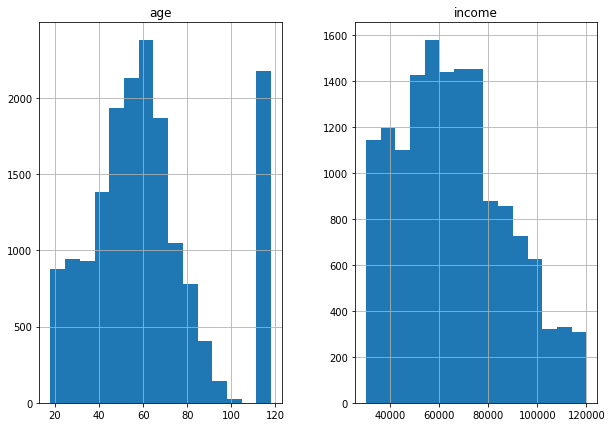

In [21]:
profile.hist(figsize=(10,7), bins=15);

* Tow main observations:
    * There is one spacific value that has been repeated a lot and it is above 100 years old to be investigated if it is true value or an outlier
    * The distribution for both age and incomer is not normal distribution some, especially for income column, where the median could be the best type of average to use for substitution

In [22]:
profile[profile['age'] > 100].groupby('age').count()

,became_member_on,gender,id,income
age,,,,
101,5,5,5,5
118,2175,0,2175,0


The above gives a clear insight over the following 3 points:
  * The age that is above the normal expected value, which is 101 and 118
  * The missing gender
  * The missing income
    
Since all the missing values of gneder an income are related to people with age of 118, this could indicate that those infromation arn't neccesserly correct, and there is no way to substitiute the missing values for the gender column at least. Moreover, since those missing value makes only 12% of the total data, it may no affect our final conclusion.

In [23]:
# Taking only values other than 118 from age column
profile_1 = profile.copy()
profile_1 = profile_1[profile_1['age'] != 118]
profile_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 5 columns):
age                 14825 non-null int64
became_member_on    14825 non-null datetime64[ns]
gender              14825 non-null object
id                  14825 non-null object
income              14825 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 694.9+ KB


In [24]:
# Changing the ID column name to person will make it easy to merge profile dataframe with transcript_updated
profile_1.rename(columns={"id": "person"}, inplace = True)

In [25]:
profile_1.head()

,age,became_member_on,gender,person,income
1,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0
3,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
5,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0
8,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0
12,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0


In [26]:
full_data = transcript_updated.merge(profile_1)
full_data.rename(columns={"person": "person_id"}, inplace = True)
full_data.head()

,event,person_id,time_hours,channels,difficulty,duration_days,offer_type,reward,age,became_member_on,gender,income
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,"[web, email, mobile]",5,7,bogo,5,75,2017-05-09,F,100000.0
1,offer viewed,78afa995795e4d85b5d9ceeca43f5fef,6,"[web, email, mobile]",5,7,bogo,5,75,2017-05-09,F,100000.0
2,offer completed,78afa995795e4d85b5d9ceeca43f5fef,132,"[web, email, mobile]",5,7,bogo,5,75,2017-05-09,F,100000.0
3,offer received,78afa995795e4d85b5d9ceeca43f5fef,504,"[web, email, mobile, social]",5,5,bogo,5,75,2017-05-09,F,100000.0
4,offer completed,78afa995795e4d85b5d9ceeca43f5fef,510,"[web, email, mobile, social]",5,5,bogo,5,75,2017-05-09,F,100000.0


In [27]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 148805 entries, 0 to 148804
Data columns (total 12 columns):
event               148805 non-null object
person_id           148805 non-null object
time_hours          148805 non-null int64
channels            148805 non-null object
difficulty          148805 non-null int64
duration_days       148805 non-null int64
offer_type          148805 non-null object
reward              148805 non-null int64
age                 148805 non-null int64
became_member_on    148805 non-null datetime64[ns]
gender              148805 non-null object
income              148805 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(5), object(5)
memory usage: 14.8+ MB


The last step now is to add the transactions to the dataframe we already have to have a complete set of data

In [28]:
transaction_df = transcript_1[transcript_1['event'] == 'transaction']

In [29]:
# We need to use the same column names for both data frame we want to merge
col = full_data.columns
# Merging the dataframe where we have the transaction events with the users profile
transaction_df1 = transaction_df.merge(profile_1)

# Renaming the some of the columns for making the merging between data frames easier
transaction_df1.rename(columns={'person': 'person_id', 'time': 'time_hours'}, inplace = True)

#Adding addtional coloumn and specifieng the values for each since transaction events has no awards, difficutly, or duration
transaction_df1['channels'] = 'No channels'
transaction_df1['difficulty'] = 0
transaction_df1['duration_days'] = 0
transaction_df1['offer_type'] = 'transaction'
transaction_df1['reward'] = 0

# Rearranging the columns in spacific order 
transaction_df1 = transaction_df1.reindex(columns=col)
transaction_df1.head(5)

,event,person_id,time_hours,channels,difficulty,duration_days,offer_type,reward,age,became_member_on,gender,income
0,transaction,02c083884c7d45b39cc68e1314fec56c,0,No channels,0,0,transaction,0,20,2016-07-11,F,30000.0
1,transaction,02c083884c7d45b39cc68e1314fec56c,6,No channels,0,0,transaction,0,20,2016-07-11,F,30000.0
2,transaction,02c083884c7d45b39cc68e1314fec56c,12,No channels,0,0,transaction,0,20,2016-07-11,F,30000.0
3,transaction,02c083884c7d45b39cc68e1314fec56c,84,No channels,0,0,transaction,0,20,2016-07-11,F,30000.0
4,transaction,02c083884c7d45b39cc68e1314fec56c,90,No channels,0,0,transaction,0,20,2016-07-11,F,30000.0


In [30]:
df = pd.concat([transaction_df1, full_data], axis=0)
df.head()

,event,person_id,time_hours,channels,difficulty,duration_days,offer_type,reward,age,became_member_on,gender,income
0,transaction,02c083884c7d45b39cc68e1314fec56c,0,No channels,0,0,transaction,0,20,2016-07-11,F,30000.0
1,transaction,02c083884c7d45b39cc68e1314fec56c,6,No channels,0,0,transaction,0,20,2016-07-11,F,30000.0
2,transaction,02c083884c7d45b39cc68e1314fec56c,12,No channels,0,0,transaction,0,20,2016-07-11,F,30000.0
3,transaction,02c083884c7d45b39cc68e1314fec56c,84,No channels,0,0,transaction,0,20,2016-07-11,F,30000.0
4,transaction,02c083884c7d45b39cc68e1314fec56c,90,No channels,0,0,transaction,0,20,2016-07-11,F,30000.0


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 272762 entries, 0 to 148804
Data columns (total 12 columns):
event               272762 non-null object
person_id           272762 non-null object
time_hours          272762 non-null int64
channels            272762 non-null object
difficulty          272762 non-null int64
duration_days       272762 non-null int64
offer_type          272762 non-null object
reward              272762 non-null int64
age                 272762 non-null int64
became_member_on    272762 non-null datetime64[ns]
gender              272762 non-null object
income              272762 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(5), object(5)
memory usage: 27.1+ MB


The cleaning of the data is completed. However, on final note needs to be highlighted which is regarding the number of records.
Since we have dropped all users with age of 118 for profile data frame, it seems that there are 33771 record related to those customers, which were excluded from the begining due to lack of data about income and gender which can't be substituted.

-------------------------------------------------------------------------------
----------------------------------------------------------------------------------

### Section 2: Data Exploaration and Visualization
#### In this section the data will be explored, and visualized to understand how different data and variables are related specifically to different demographic groups

1. General statisitics about numeric variables in the dataframe

In [32]:
df.describe()

,time_hours,difficulty,duration_days,reward,age,income
count,272762.000000,272762.000000,272762.000000,272762.000000,272762.000000,272762.000000
mean,366.707694,4.304687,3.614374,2.423571,53.840696,64337.000755
std,200.359087,5.413062,3.655745,3.331264,17.551337,21243.762941
min,0.000000,0.000000,0.000000,0.000000,18.000000,30000.000000
25%,186.000000,0.000000,0.000000,0.000000,41.000000,48000.000000
50%,408.000000,0.000000,3.000000,0.000000,55.000000,62000.000000
75%,528.000000,10.000000,7.000000,5.000000,66.000000,78000.000000
max,714.000000,20.000000,10.000000,10.000000,101.000000,120000.000000


*The total number of days for having the experiment ran is almost 30 days*

2. Checking number of males, females, other genders across the data set to check for any umbalance, and their distribution related to cutomers income and age

In [33]:
gender_distribution = df.groupby('gender')[['gender']].count()

In [34]:
gender_distribution = gender_distribution.sort_values(by = 'gender', ascending=False)
gender_distribution

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: 'gender' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  """Entry point for launching an IPython kernel.


,gender
gender,
M,155690
F,113101
O,3971


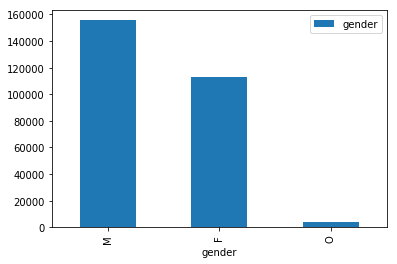

In [35]:
gender_distribution.plot.bar();

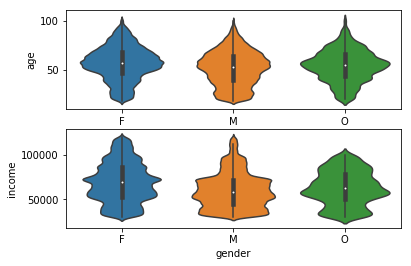

In [36]:
fig, axes = plt.subplots(2, 1)
sns.violinplot(data=df, x= 'gender', y='age', ax=axes[0])
sns.violinplot(data=df, x= 'gender', y='income', ax=axes[1])

In [37]:
gender_age_income = df.groupby('gender')['age', 'income'].mean()
gender_age_income

,age,income
gender,,
F,56.735564,69546.750250
M,51.730580,60589.087289
O,54.120625,62897.758751


It can be seen from the above that age distribution across all three genders is similar. Yet for the income there is a slight difference. As most males customers earn less then female customers on average. While the customers whose gender not identified in the dataframe, their maximum income is less than males and females customers.

3. Understanding the age and income distribution and their relationship

In [38]:
df[['age','income']].corr()

,age,income
age,1.000000,0.298744
income,0.298744,1.000000


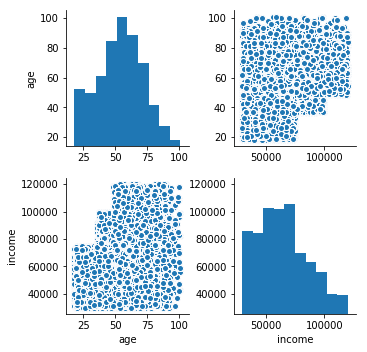

In [39]:
sns.pairplot(df[['age','income']])

From above it can be seen the following:
* The correlation between age and income is low, yet certien age groups earns less than the general maximum
* The distribution of the ages isn't normal but yet close to it.
* The distribution of the income isn't normal skewed to the left.

3. Ensuring the distribution of types of offers, usually since this is a test, it should be distributed equally.

In [40]:
offers = df.groupby('offer_type')[['offer_type']].count()

In [41]:
offers

,offer_type
offer_type,
bogo,63834
discount,62311
informational,22660
transaction,123957


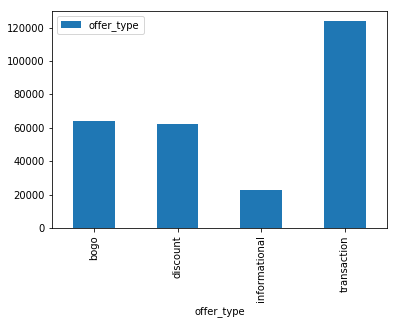

In [42]:
offers.plot.bar()

In [43]:
df.groupby(['offer_type', 'event'])[['event']].count()

event
offer_type    event                  
bogo          offer completed   15258
              offer received    26537
              offer viewed      22039
discount      offer completed   17186
              offer received    26664
              offer viewed      18461
informational offer received    13300
              offer viewed       9360
transaction   transaction      123957

It seems that the number of discounts and bogo offers are almost equal. Yet the informational offers are the lowest.
The informational can be linked later on with the transactions to see if informational offer would influence a customer to make a purchase

4. The last part to explore is the number of events recieved, reviewed, and completed related to each offer

In [44]:
df[df['offer_type'] != 'transaction'].groupby(['offer_type','event'])[['event']].count()

event
offer_type    event                 
bogo          offer completed  15258
              offer received   26537
              offer viewed     22039
discount      offer completed  17186
              offer received   26664
              offer viewed     18461
informational offer received   13300
              offer viewed      9360

From above it can be seen that 83% of the recieved dicsount offer are completed, while 0.69% of the bogo recieved offers are completed. On the other hand 57% of the recieved dicsount offer are viewed, while 64% of the bogo recieved offers are viewed.

*Note:* this doesn't take into account if those completed offers are viwed or not. Which is going to be explored later once the custmers are clustered and grouped.

The exploaration of data and visualization is completed with the following summery:
* The gender distribution is imbalanced where number of males is higher than females by 37% 
* The three different gender groups are similar in distribution when it comes to age, with average age of 56 for females, 51 for males and 54 for others unspecified genders. 
* The three different gender groups are slightly different in distribution when it comes to income, with average income of 70,000 for females, 60,500 for males and 63,000 for others unspecified genders. 
* There correlation between age and income is low with 0.3. Addtionally, age and income distribution across all customers is not normal and skewed to left.
* bogo and discount offers are almost equal.

--------------------------------------------------------------------
____________________________________________________________________

### Section 3: Data Analysis
#### In this section the data will be analyzed and clusters will be made based on demographic groups, and then analyzes how each group reacts for each type of offers

1. Specifying the varibales customers will be clustered based on, which are going to be age, income, and gender. So first a copy of the original dataframe is needed

In [45]:
df_clustering = df.copy()
df_clustering = df_clustering[['age', 'income', 'gender']]
df_clustering.shape

(272762, 3)

2. Clustring preprocessing function will be built to perform two functions: normalize numiric variables and create a dummy variables out of categorical variables

In [46]:
#preprocessing function

def preprocess_func(cat_col, num_col, df):
    '''
    The purpose of this function is to do preprocessing for dataframe before clustring
    The preprocessing will be divided to two parts: encoding categorical variables and normalzing numirical ones
    * input:
        - cat_col: list of categorical variabels
        - num_col: list of numirical variabels
        - df: dataframe to be used
    * output: 
        - Normalized and encoded dataframe
    '''
    scaler = MinMaxScaler()
    for col in num_col:
        df[col] = scaler.fit_transform(np.array(df[col]).reshape(-1,1))

    df_dummy = pd.get_dummies(df, columns=cat_col)
    return df_dummy


In [47]:
df_processed = preprocess_func(['gender'], ['age', 'income'], df_clustering)

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [48]:
df_processed.head()

,age,income,gender_F,gender_M,gender_O
0,0.024096,0.0,1,0,0
1,0.024096,0.0,1,0,0
2,0.024096,0.0,1,0,0
3,0.024096,0.0,1,0,0
4,0.024096,0.0,1,0,0


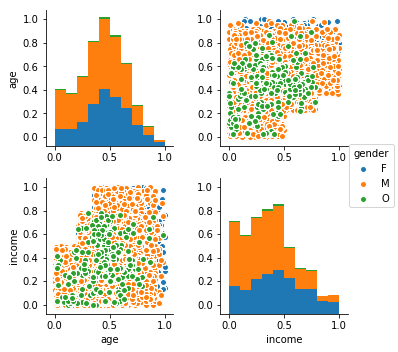

In [49]:
sns.pairplot(data = df_clustering, hue='gender')

3. Then the a fucntion that would evaluate the the best number of cluster needed to use kmeans clustring

In [50]:
# Checking the best number of cluster
def num_clusters(data, k):
    '''
    This function plots the inertia for each clustring process is done in order to pick the optimal number of clusters
    * input:
        - data: dataframe
        - k: maximum number of clusters to be plotted.
    * output:
        - elbow plot to show the inertia for each number of clusters
        - Calinski Harabaz score for each number of clusters to choose the one with higher score
    '''
    SSD = []
    for k in range(1, k+1):
        kmeans = KMeans(n_clusters=k, random_state=0).fit(data)
        SSD.append(kmeans.inertia_)
        if k >= 2:
            print('for number of clusters = {}, the calinski harabaz score = {}'.format(k, calinski_harabaz_score(data, kmeans.labels_)))

    
    
    plt.plot(range(1, k+1), SSD)
    plt.xticks(range(1, k+1))
    plt.show()
    

for number of clusters = 2, the calinski harabaz score = 1037762.4708733119
for number of clusters = 3, the calinski harabaz score = 709169.416836647
for number of clusters = 4, the calinski harabaz score = 642111.0173305903
for number of clusters = 5, the calinski harabaz score = 682731.0601833878
for number of clusters = 6, the calinski harabaz score = 700245.9672476589
for number of clusters = 7, the calinski harabaz score = 712185.7631037824
for number of clusters = 8, the calinski harabaz score = 689509.6114157
for number of clusters = 9, the calinski harabaz score = 676161.962916541


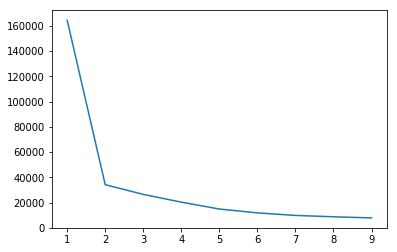

In [51]:
# checking the best number of clusters for the newly processed data frame

num_clusters(df_processed, 9)

It can be seen from the elbow plot in the above chart & the calinski_harabaz_score it seems that having 2 clusters is the optimum number of clusters 

In [52]:
# Model of clustring
kmeans = KMeans(n_clusters=2, random_state=0).fit(df_processed)

In [53]:
df_processed['clusters'] = kmeans.labels_
df_processed.head()

,age,income,gender_F,gender_M,gender_O,clusters
0,0.024096,0.0,1,0,0,0
1,0.024096,0.0,1,0,0,0
2,0.024096,0.0,1,0,0,0
3,0.024096,0.0,1,0,0,0
4,0.024096,0.0,1,0,0,0


In [54]:
df_final = pd.concat([df, df_processed[['clusters']]], axis = 1)
df_final.head()

,event,person_id,time_hours,channels,difficulty,duration_days,offer_type,reward,age,became_member_on,gender,income,clusters
0,transaction,02c083884c7d45b39cc68e1314fec56c,0,No channels,0,0,transaction,0,20,2016-07-11,F,30000.0,0
1,transaction,02c083884c7d45b39cc68e1314fec56c,6,No channels,0,0,transaction,0,20,2016-07-11,F,30000.0,0
2,transaction,02c083884c7d45b39cc68e1314fec56c,12,No channels,0,0,transaction,0,20,2016-07-11,F,30000.0,0
3,transaction,02c083884c7d45b39cc68e1314fec56c,84,No channels,0,0,transaction,0,20,2016-07-11,F,30000.0,0
4,transaction,02c083884c7d45b39cc68e1314fec56c,90,No channels,0,0,transaction,0,20,2016-07-11,F,30000.0,0


4. Analyzing what is the age group for each cluster, income, and gender

In [55]:
df_final.groupby(['clusters', 'gender']).agg({"age" : [min, max, 'mean'], "income" : [min, max, 'mean']})

age                   income                        
                min  max       mean      min       max          mean
clusters gender                                                     
0        F       18  101  56.735564  30000.0  120000.0  69546.750250
         O       20  100  54.120625  30000.0  100000.0  62897.758751
1        M       18  100  51.730580  30000.0  120000.0  60589.087289

In [56]:
df_final['clusters'] = df_final['clusters'].replace({0: 'Females Cluster', 1: 'Males Cluster'})

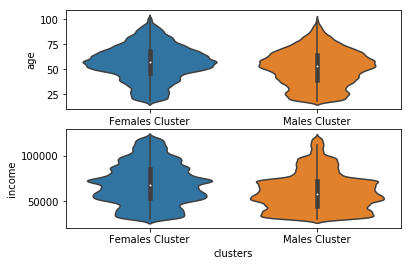

In [57]:
fig, axes = plt.subplots(2, 1)
sns.violinplot(data=df_final, x= 'clusters', y='age', ax=axes[0])
sns.violinplot(data=df_final, x= 'clusters', y='income', ax=axes[1])

From the clusters above we can say there are males and females clusters. The males cluster has lower income in general comapred to the female cluster & they it has more young people in general.

In [58]:
Clusters_trends = df_final.groupby(['clusters','offer_type','event'])[['event']].count()
Clusters_trends

event
clusters        offer_type    event                 
Females Cluster bogo          offer completed   7746
                              offer received   11329
                              offer viewed      9458
                discount      offer completed   8232
                              offer received   11310
                              offer viewed      8030
                informational offer received    5733
                              offer viewed      4071
                transaction   transaction      51163
Males Cluster   bogo          offer completed   7512
                              offer received   15208
                              offer viewed     12581
                discount      offer completed   8954
                              offer received   15354
                              offer viewed     10431
                informational offer received    7567
                              offer viewed      5289
                transaction   transaction      72794

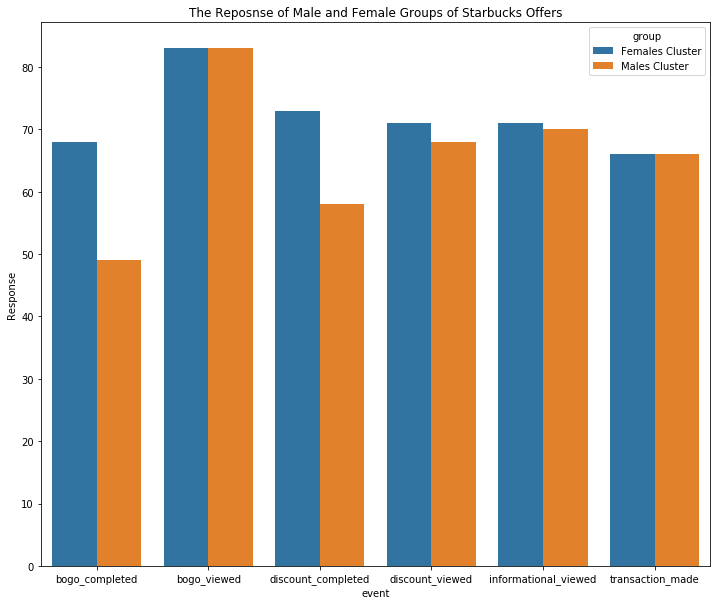

In [117]:
prob_group_F = {'bogo_completed' : round(7746/11329, 2), 'bogo_viewed' : round(9458/11329 ,2),
                'discount_completed' : round(8232/11310 ,2), 'discount_viewed' : round(8030/11310 ,2),
                'informational_viewed' : round(4071/5733 ,2), 'transaction_made' : round(51163/(11310+11329+4071+51163) ,2)}

prob_group_M = {'bogo_completed' : round(7512/15208 ,2), 'bogo_viewed' : round(12581/15208 ,2),
                'discount_completed' : round(8954/15354 ,2), 'discount_viewed' : round(10431/15354 ,2),
                'informational_viewed' : round(5289/7567 ,2), 'transaction_made' : round(72794/(72794+15354+15208+7567) ,2)}

data_items = prob_group_F.items()
data_list = list(data_items)

dff = pd.DataFrame(data_list)
dff['group'] = 'Females Cluster'
dff.rename(columns = {0: 'event', 1:'Response'}, inplace=True)

data_items = prob_group_M.items()
data_list = list(data_items)

dfm = pd.DataFrame(data_list)
dfm['group'] = 'Males Cluster'
dfm.rename(columns = {0: 'event', 1:'Response'}, inplace=True)


pdList = [dff, dfm]  # List of your dataframes
new_dfg = pd.concat(pdList, axis=0)
new_dfg.reset_index().drop(['index'], axis = 1, inplace=True)

new_dfg['Response'] = new_dfg['Response']*100

fig_dims = (12, 10)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x="event", y="Response", hue="group", data=new_dfg)
plt.title('The Reposnse of Male and Female Groups of Starbucks Offers');

In [59]:
print('Female cluster has completed {}% of the recieved bogo offers, and {}% of the discount offers. while viewing {}% and {}% bogo and discount offers respectivly'.format(round(7746/11329, 2)*100, round(8232/11310, 2)*100, round(9458/11329,2)*100, round(8030/11310, 2)*100))

Female cluster has completed 68.0% of the recieved bogo offers, and 73.0% of the discount offers. while viewing 83.0% and 71.0% bogo and discount offers respectivly


In [60]:
print('Male cluster has completed {}% of the recieved bogo offers, and {}% of the discount offers. while viewing {}% and {}% bogo and discount offers respectivly'.format(round(7512/15208, 2)*100, round(8954/15354, 2)*100, round(12581/15208,2)*100, round(10431/15354, 2)*100))

Male cluster has completed 49.0% of the recieved bogo offers, and 57.99999999999999% of the discount offers. while viewing 83.0% and 68.0% bogo and discount offers respectivly


In [61]:
print('Female cluster has viewed {}% of the recieved informational offers. While male cluster has viewed {}% of the recieved informational offers '.format(round(4071/5733, 2)*100, round(5289/7567, 2)*100))

Female cluster has viewed 71.0% of the recieved informational offers. While male cluster has viewed 70.0% of the recieved informational offers 


In [62]:
print('Male customers made {}% more transaction than female customers unrelated to BOGO or discount offers'.format(round(72794/51163, 2)*100))

Male customers made 142.0% more transaction than female customers unrelated to BOGO or discount offers


From above it can be seen that cluster 0, which consists of females and other gender type, are more responsive toward offers sent to them in general in contrast to the second cluster which consists only from males. On the other hand, male group tend to do direct transaction more than females group. <br/>


We need to divide each cluster to smaller clusters and find how they behave toward offers and which age group and income group respond more to offers

In [63]:
df_cluster_0 = df_final[df_final['clusters'] == 'Females Cluster']

In [64]:
df_C0 = df_cluster_0[['age', 'income']]
scaler = MinMaxScaler()
df_C0['age']= scaler.fit_transform(np.array(df_C0['age']).reshape(-1,1))
df_C0['income']= scaler.fit_transform(np.array(df_C0['income']).reshape(-1,1))

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.

In [65]:
df_cluster_1 = df_final[df_final['clusters'] == 'Males Cluster']
df_C1 = df_cluster_1[['age', 'income']]
df_C1['age']= scaler.fit_transform(np.array(df_C1['age']).reshape(-1,1))
df_C1['income']= scaler.fit_transform(np.array(df_C1['income']).reshape(-1,1))

/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.

for number of clusters = 2, the calinski harabaz score = 101124.18355806427
for number of clusters = 3, the calinski harabaz score = 102462.25073217851
for number of clusters = 4, the calinski harabaz score = 97265.78722628934
for number of clusters = 5, the calinski harabaz score = 99569.07990151348
for number of clusters = 6, the calinski harabaz score = 95734.22049928151
for number of clusters = 7, the calinski harabaz score = 95664.33032906112


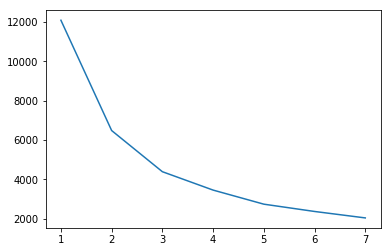

In [66]:
num_clusters(df_C0, 7)

for number of clusters = 2, the calinski harabaz score = 114531.5852941205
for number of clusters = 3, the calinski harabaz score = 135344.4823705469
for number of clusters = 4, the calinski harabaz score = 126031.98482500992
for number of clusters = 5, the calinski harabaz score = 126440.41655376174
for number of clusters = 6, the calinski harabaz score = 127592.94352672578
for number of clusters = 7, the calinski harabaz score = 128611.43319465168
for number of clusters = 8, the calinski harabaz score = 129188.44806020544
for number of clusters = 9, the calinski harabaz score = 127673.57408642262


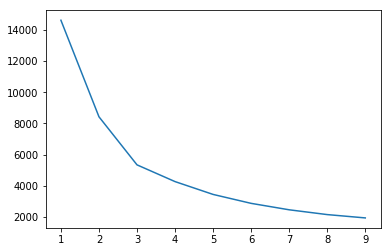

In [67]:
num_clusters(df_C1, 9)

The best number of for dividing clusters to sub_clusters is 3 

In [68]:
kmeans0 = KMeans(n_clusters=3, random_state=0).fit(df_C0)
kmeans1 = KMeans(n_clusters=3, random_state=0).fit(df_C1)

In [69]:
df_C0['sub_clusters'] = kmeans0.labels_
df_C1['sub_clusters'] = kmeans1.labels_

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [70]:
df_cluster_0 = pd.concat([df_cluster_0, df_C0[['sub_clusters']]], axis = 1)
df_cluster_1 = pd.concat([df_cluster_1, df_C1[['sub_clusters']]], axis = 1)

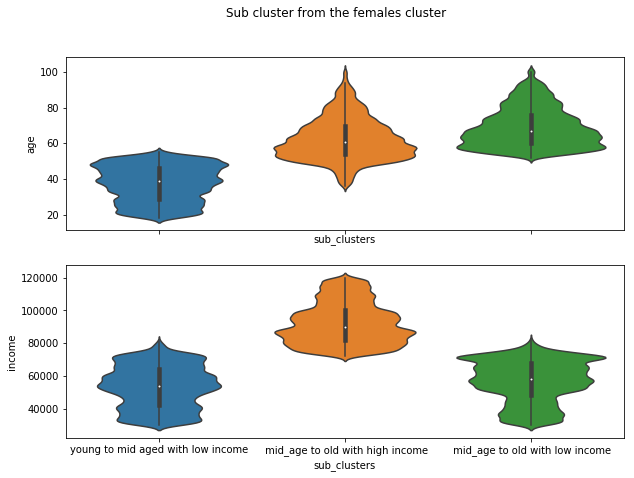

In [100]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize = (10, 7))
plt.suptitle('Sub cluster from the females cluster')
sns.violinplot(data=df_cluster_0, x= 'sub_clusters', y='age', ax=axes[0])
sns.violinplot(data=df_cluster_0, x= 'sub_clusters', y='income', ax=axes[1]);


In [74]:
df_cluster_0['sub_clusters'] = df_cluster_0['sub_clusters'].replace({0: ' mid_age to old with high income',
                                                                     1: 'young to mid aged with low income',
                                                                     2: ' mid_age to old with low income'})

In [76]:
df_cluster_0.groupby('sub_clusters').agg({"age" : [min, max, 'mean'], "income" : [min, max, 'mean']})

age                   income            \
                                  min  max       mean      min       max   
sub_clusters                                                               
 mid_age to old with high income   36  101  62.407669  72000.0  120000.0   
 mid_age to old with low income    52  101  69.176879  30000.0   82000.0   
young to mid aged with low income  18   55  37.581084  30000.0   81000.0   

                                                 
                                           mean  
sub_clusters                                     
 mid_age to old with high income   92265.429473  
 mid_age to old with low income    56897.479181  
young to mid aged with low income  53493.800364

In [77]:
df_cluster_0.groupby(['sub_clusters','offer_type','event'])[['event']].count()

event
sub_clusters                      offer_type    event                 
 mid_age to old with high income  bogo          offer completed   3538
                                                offer received    4731
                                                offer viewed      3844
                                  discount      offer completed   3721
                                                offer received    4713
                                                offer viewed      3376
                                  informational offer received    2400
                                                offer viewed      1618
                                  transaction   transaction      16730
 mid_age to old with low income   bogo          offer completed   2155
                                                offer received    3339
                                                offer viewed      2851
                                  discount      offer completed   2311
                                                offer received    3337
                                                offer viewed      2444
                                  informational offer received    1640
                                                offer viewed      1226
                                  transaction   transaction      16241
young to mid aged with low income bogo          offer completed   2053
                                                offer received    3259
                                                offer viewed      2763
                                  discount      offer completed   2200
                                                offer received    3260
                                                offer viewed      2210
                                  informational offer received    1693
                                                offer viewed      1227
                                  transaction   transaction      18192

In [78]:
prob_group_a = {'bogo_completed' : round(3538/4731 ,2), 'bogo_viewed' : round(3844/4731 ,2),
                'discount_completed' : round(3721/4713 ,2), 'discount_viewed' : round(3376/4713 ,2),
                'informational_viewed' : round(1618/2400 ,2), 'transaction_made' : round(16730/(4731+4713+2400+16730) ,2)}

prob_group_b = {'bogo_completed' : round(2155/3339 ,2), 'bogo_viewed' : round(2851/3339 ,2),
                'discount_completed' : round(2311/3337 ,2), 'discount_viewed' : round(2444/3337 ,2),
                'informational_viewed' : round(1226/1640 ,2), 'transaction_made' : round(16241/(1640+3339+3337+16241) ,2)}

prob_group_c = {'bogo_completed' : round(2053/3259 ,2), 'bogo_viewed' : round(2763/3259 ,2),
                'discount_completed' : round(2200/3260 ,2), 'discount_viewed' : round(2210/3260 ,2),
                'informational_viewed' : round(1227/1693 ,2), 'transaction_made' : round(18192/(1693+3260+3259+18192) ,2)}



In [79]:
data_items = prob_group_a.items()
data_list = list(data_items)

dfa = pd.DataFrame(data_list)
dfa['group'] = 'Females: mid_age to old with high income'
dfa.rename(columns = {0: 'event', 1:'Response'}, inplace=True)

data_items = prob_group_b.items()
data_list = list(data_items)

dfb = pd.DataFrame(data_list)
dfb['group'] = 'Females: mid_age to old with low income'
dfb.rename(columns = {0: 'event', 1:'Response'}, inplace=True)

data_items = prob_group_c.items()
data_list = list(data_items)

dfc = pd.DataFrame(data_list)
dfc['group'] = 'Females: young to mid age with low income'
dfc.rename(columns = {0: 'event', 1:'Response'}, inplace=True)



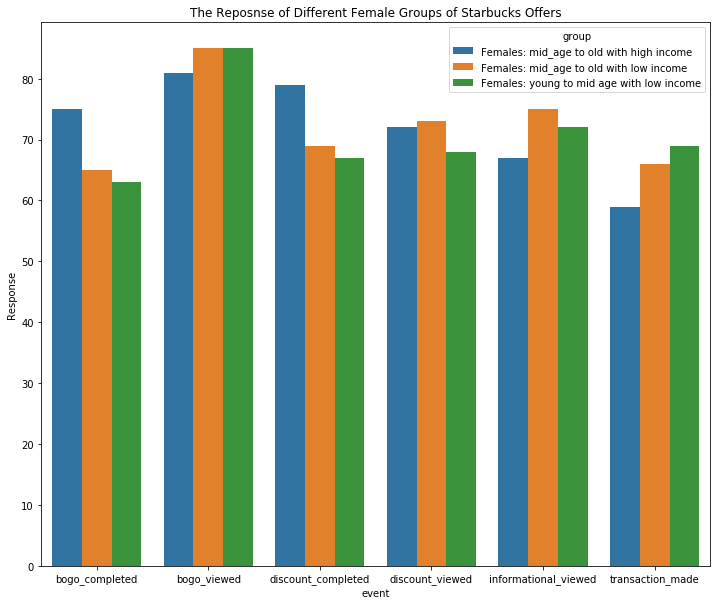

In [80]:
pdList = [dfa, dfb, dfc]  # List of your dataframes
new_df1 = pd.concat(pdList, axis=0)
new_df1.reset_index().drop(['index'], axis = 1, inplace=True)

new_df1['Response'] = new_df1['Response']*100

fig_dims = (12, 10)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x="event", y="Response", hue="group", data=new_df1)
plt.title('The Reposnse of Different Female Groups of Starbucks Offers');

Regarding the Females different age and income groups, it can be seen that Females with high income have more tendency to complete the offers sent to them. While low income groups they view thos offers the most and have lower response than the the income group. On the other hand, low income groups tend to do more transactions that unrealted to any offer.

Since low income group has two age category, Young to Mid_age group & Mid_age to Young group, from age prespective it can be seen that the younger group tend to have more transcactions than the old ones

------------------------------

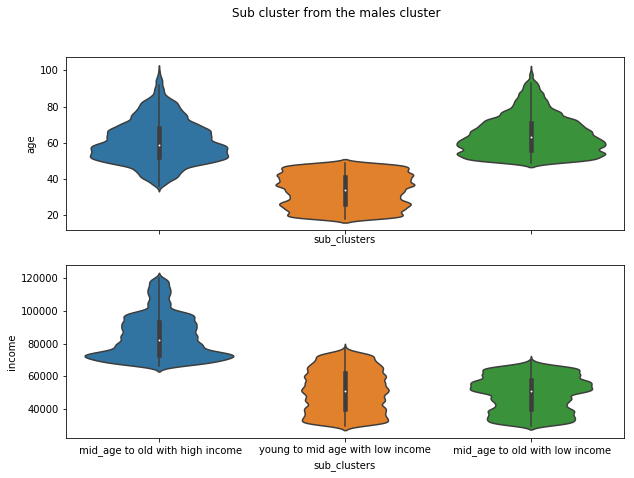

In [99]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize = (10, 7))
plt.suptitle('Sub cluster from the males cluster')
sns.violinplot(data=df_cluster_1, x= 'sub_clusters', y='age', ax=axes[0])
sns.violinplot(data=df_cluster_1, x= 'sub_clusters', y='income', ax=axes[1]);


In [95]:
df_cluster_1['sub_clusters'] = df_cluster_1['sub_clusters'].replace({0: ' mid_age to old with low income',
                                                                     1: 'young to mid age with low income',
                                                                     2: ' mid_age to old with high income'})

In [84]:
df_cluster_1.groupby('sub_clusters').agg({"age" : [min, max, 'mean'], "income" : [min, max, 'mean']})

age                   income            \
                                 min  max       mean      min       max   
sub_clusters                                                              
 mid_age to old with high income  36  100  60.870528  66000.0  120000.0   
 mid_age to old with low income   49  100  64.394928  30000.0   70000.0   
young to mid age with low income  18   49  33.703537  30000.0   77000.0   

                                                
                                          mean  
sub_clusters                                    
 mid_age to old with high income  84450.175749  
 mid_age to old with low income   49476.953908  
young to mid age with low income  51313.995723

In [85]:
df_cluster_1.event.count()

155690

In [86]:
df_cluster_1.groupby(['sub_clusters','offer_type','event'])[['event']].count()

event
sub_clusters                     offer_type    event                 
 mid_age to old with high income bogo          offer completed   3272
                                               offer received    4811
                                               offer viewed      4047
                                 discount      offer completed   3555
                                               offer received    4798
                                               offer viewed      3636
                                 informational offer received    2301
                                               offer viewed      1683
                                 transaction   transaction      18270
 mid_age to old with low income  bogo          offer completed   2029
                                               offer received    4853
                                               offer viewed      4014
                                 discount      offer completed   2511
                                               offer received    4892
                                               offer viewed      3265
                                 informational offer received    2514
                                               offer viewed      1755
                                 transaction   transaction      24566
young to mid age with low income bogo          offer completed   2211
                                               offer received    5544
                                               offer viewed      4520
                                 discount      offer completed   2888
                                               offer received    5664
                                               offer viewed      3530
                                 informational offer received    2752
                                               offer viewed      1851
                                 transaction   transaction      29958

In [87]:
# from above, we can get the following percentage:

prob_group_1 = {'bogo_completed' : round(3272/4811 ,2), 'bogo_viewed' : round(4047/4811 ,2),
                'discount_completed' : round(3555/4798 ,2), 'discount_viewed' : round(3636/4798 ,2),
                'informational_viewed' : round(1683/2301 ,2), 'transaction_made' : round(18270/(4811+4798+2301+18270) ,2)}

prob_group_2 = {'bogo_completed' : round(2029/4853 ,2), 'bogo_viewed' : round(4014/5544 ,2),
                'discount_completed' : round(2511/4892 ,2), 'discount_viewed' : round(3265/4892 ,2),
                'informational_viewed' : round(1755/2514 ,2), 'transaction_made' : round(24566/(4892+4853+2514+24566) ,2)}

prob_group_3 = {'bogo_completed' : round(2211/5544 ,2), 'bogo_viewed' : round(4520/4811 ,2),
                'discount_completed' : round(2888/5664 ,2), 'discount_viewed' : round(3530/5664 ,2),
                'informational_viewed' : round(1851/2752 ,2), 'transaction_made' : round(29958/(2752+4811+5664+29958) ,2)}

In [88]:
data_items = prob_group_1.items()
data_list = list(data_items)

df0 = pd.DataFrame(data_list)
df0['group'] = 'Men: mid_age to old with high income'
df0.rename(columns = {0: 'event', 1:'activity_percentage'}, inplace=True)

In [89]:
data_items = prob_group_2.items()
data_list = list(data_items)

df1 = pd.DataFrame(data_list)
df1['group'] = 'Men: mid_age to old with low income'
df1.rename(columns = {0: 'event', 1:'activity_percentage'}, inplace=True)

In [90]:
data_items = prob_group_3.items()
data_list = list(data_items)

df2 = pd.DataFrame(data_list)
df2['group'] = 'Men: young to mid age with low income'
df2.rename(columns = {0: 'event', 1:'activity_percentage'}, inplace=True)

In [91]:
pdList = [df0, df1, df2]  # List of your dataframes
new_df = pd.concat(pdList, axis=0)
new_df.reset_index().drop(['index'], axis = 1, inplace=True)

In [92]:
new_df.rename(columns = {'activity_percentage': 'Response'}, inplace=True)

In [93]:
new_df['Response'] = new_df['Response']*100

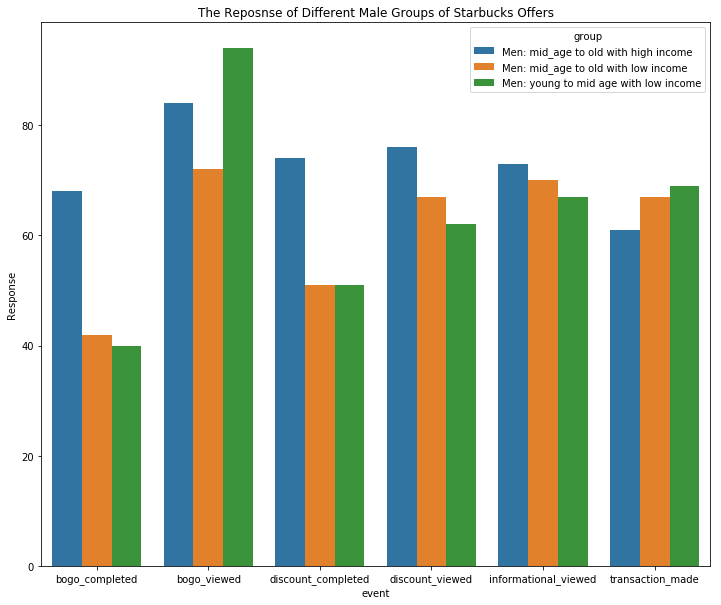

In [94]:
fig_dims = (12, 10)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x="event", y="Response", hue="group", data=new_df)
plt.title('The Reposnse of Different Male Groups of Starbucks Offers');

Regarding the Males different age and income groups, it can be seen that Males with high income have more tendency to complete the offers sent to them. While low income groups they view thos offers the most and have lower response than the the income group. On the other hand, low income groups tend to do more transactions that unrealted to any offer.

Since low income group has two age category, Young to Mid_age group & Mid_age to Young group, from age prespective it can be seen that the younger group tend to have more transcactions than the old one.

------------------------------------------------------------
----------------------------------------------------------

## Conclusion

### Summary of the problem
The main goal of this project was to analyze the reponse of different customrs toward Starbucks offers. This was done by first dividing those customers based on demographical inforamtion provided: age, income, and gender. By applying unsupervised machine learning model of K means clustring, the customers were devided to two main clusters Males and Females clusters. It worth noting that that there are some customers who didn't identify there gender and select Others and they make only 1% of the customers. While 57% of the customers are from females and the remaining 42% are from the male customers.

Those two groups were similarly devided to three sub groups:
* High income group with customers' between their early 40's to 100 (Mid_age to old)
* Low income group with customers' between their early 50's to 100 (Mid_age to old)
* Low income group with customers' between their early 20's to early 50's (Young to mid_age)

The following was found:
1. Females are more responsive to both offers (buy-one-get-one & discount offers) than the males.
2. It seems that even though the number of offers viewed bu both genders are high, yet it doesn't to be reflected especially for females. The main exception would the discount offer viewed by male customers, where they completed 58% of the offers recieved and viewd 68%.
3. The sub_groubs for both genders have shown similar pattern where the high income customers have completed more offers than the two low income sub groups.
4. Females customers with low income view the offers more than high income females
5. Young to Mid_age customers are make the most transaction with out recieving an offer

### Improvement

In order to have more solid analysis as whether high income customers repond more to offers than others, it is better to have a record of history where offers weren't sent at all. Then to be compared with the current history we have in order to truly state that an actual difference in purchasing habit exists.